In [3]:
import sys
import csv
import math
import aubio
import numpy as np
import matplotlib.pyplot as plt

## Let's Test it With One Recording

We'll start with this transcendental [performance by the National Symphony Orchestra](https://www.youtube.com/watch?v=HNkKjJY_ZRE)  

In [4]:
name = "nso"
filename = "../samples/%s.wav" % name

In [5]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024
TOLERANCE = 0.8
METHOD = 'yinfft'

### Target Frequencies
The score, the clarinet runs from the G below Middle C to the C two octactives about. Because a clarinet is tuned to Bb, this is transposed down to F to Bb. In [modern tuning](https://en.wikipedia.org/wiki/Piano_key_frequencies), that's F3 (key #33) to Bb5 (key #62) on a piano, which is easy to calculate:

In [6]:
def getPianoFrequency(key_number):
    return np.power(2, (key_number-49) / 12) * 440

In [7]:
F3 = getPianoFrequency(33)
Bb5 = getPianoFrequency(62)
intermediateNotes = [ getPianoFrequency(f) for f in range(34,62) ]

In [8]:
def loadFrequencies(filename):
    pitches = []
    s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
    pitch_o = aubio.pitch(METHOD, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
    pitch_o.set_unit("Hz")
    pitch_o.set_tolerance(TOLERANCE)
    total_frames = 0
    while True:
        samples, read = s()
        pitch = pitch_o(samples)[0]
        pitches += [pitch]
        total_frames += read
        if read < HOP_SIZE: 
            print("read %s frames from %s with method %s" % (total_frames, filename, METHOD))
            break
        
    # sometimes the first few pitches are off the charts        
    while abs(pitches[0] - F3) > 50:
        pitches.pop(0)
        
    return pitches

In [9]:
def plotFrequencies(pitch_group, name, chartName, showPlot=True, savePlot=False):
    #pitch_group = np.array(pitch_group)
    fig = plt.figure(figsize=(12, 9), frameon=True)
    plt.title(name + ": " + chartName, fontsize=24)
    plt.hlines([F3, Bb5], xmin=0, xmax=len(pitch_group), linestyles="dashed", colors=["#00FF00", "#990000"])
    plt.hlines(intermediateNotes, xmin=0, xmax=len(pitch_group), linestyles="dotted", colors="#CCCCCC")
    ax = fig.gca()
    ax.tick_params(labelsize=18)
    
    for (i,c) in enumerate(pitch_group):
        if type(c) == tuple:
            ax.scatter(i,c[0], color=c[1], s=12)
        else:
            ax.scatter(i,c, color="green", s=12)    
            
    #ax.plot(list(range(len(pitch_group))), pitch_group, '.g', color="green")
    if showPlot:
        plt.grid()
        plt.show()
    else:
        plt.close(fig)
        
    if savePlot:
        image_path = "../output/images/%s_%s.png" % (name, chartName)
        fig.savefig(image_path, pad_inches=1, dpi=300)

read 238124 frames from ../samples/nso.wav with method yinfft


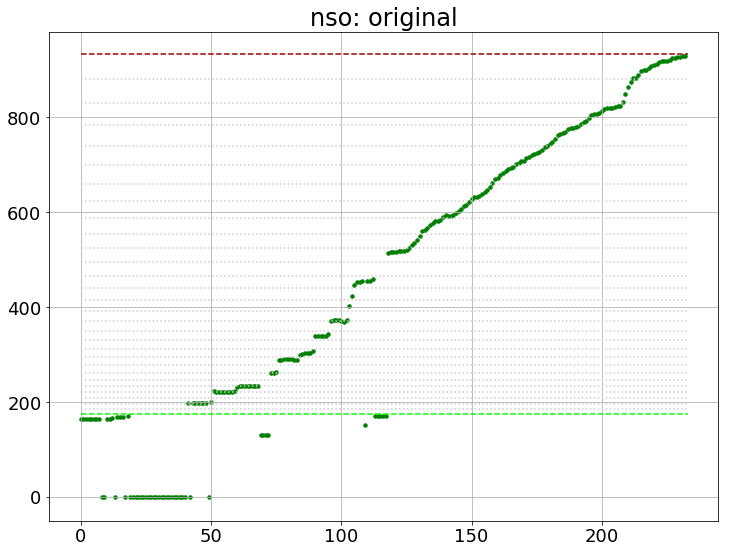

In [10]:
pitches = loadFrequencies(filename)
plotFrequencies(pitches, name, "original")

In [9]:
# identify all the outliers and move into the always-rising range

THRESHOLD = 0.001

def correctPitches(pitches, name):
    corrected = [ ( pitch, "green" ) for pitch in pitches ]

    for i in range(1, len(corrected)):
        current = corrected[i][0]
        previous = corrected[i-1][0]
        diff = (previous - current) / previous

        if diff > THRESHOLD:
            if (i < len(corrected) - 1 and (corrected[i+1][0] - previous) / previous > THRESHOLD):
                average = (previous + corrected[i+1][0]) / 2
                #print("averaging", i, current, corrected[i+1][0], previous, diff, average)
                corrected[i] = ( average, "orange" )
            else:
                #print('moving up note at %s from %s to %s (%s)' % (i, current, previous, diff))                
                corrected[i] = ( previous, "red" )

    data_path = "../output/data/%s.csv" % name

    with open(data_path, "w") as csvfile:
        spamwriter = csv.writer(csvfile)
        spamwriter.writerow(["freq"])    
        spamwriter.writerows(map(lambda x: [x[0]], corrected))                        
        print('Wrote corrected frequencies to ../output/data/%s.csv' % name)
                
    return corrected

Wrote corrected frequencies to ../output/data/nso.csv


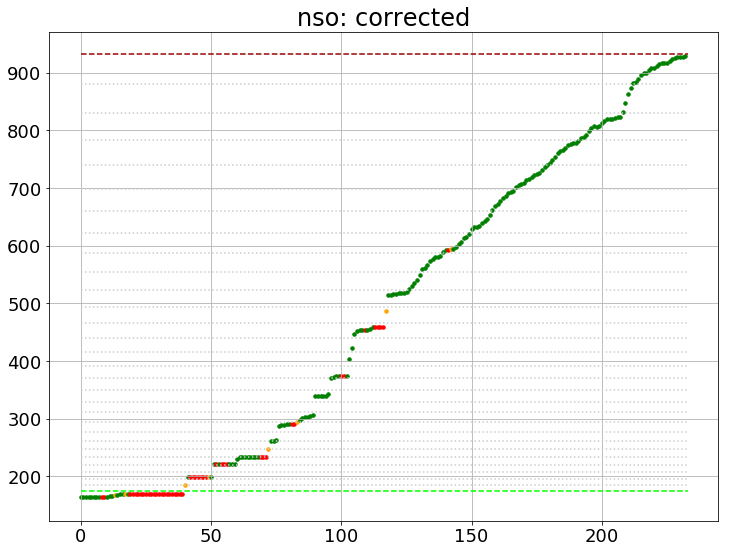

In [10]:
corrected = correctPitches(pitches, name)
plotFrequencies(corrected, name, "corrected", True, False)

## Let's try it for all of them!

In [11]:
names = ["columbia", "nso", "philadelphia", "royal", "slovak", "london"]
filenames = [ '../samples/%s.wav' % name for name in names ]

In [21]:
for (name, filename) in zip(names, filenames):
    #print(name, filename)
    pitches = loadFrequencies(filename)
    plotFrequencies(pitches, name, "original", False, True)
    corrected = correctPitches(pitches, name)
    plotFrequencies(corrected, name, "corrected", False, True)

read 127874 frames from ../samples/columbia.wav with method yinfft
Wrote corrected frequencies to ../output/data/columbia.csv
read 238124 frames from ../samples/nso.wav with method yinfft
Wrote corrected frequencies to ../output/data/nso.csv
read 189932 frames from ../samples/philadelphia.wav with method yinfft
Wrote corrected frequencies to ../output/data/philadelphia.csv
read 154334 frames from ../samples/royal.wav with method yinfft
Wrote corrected frequencies to ../output/data/royal.csv
read 149924 frames from ../samples/slovak.wav with method yinfft
Wrote corrected frequencies to ../output/data/slovak.csv
read 149924 frames from ../samples/london.wav with method yinfft
Wrote corrected frequencies to ../output/data/london.csv
